In [1]:
import pickle
import time
import os 
import numpy as np 
import matplotlib.pyplot as plt 
import Bayesian_MT_Analysis_Input_Data
import Bayesian_MT_Methods
import random
from collections import defaultdict
from joblib import Parallel, delayed
from matplotlib.colors import Normalize
from scipy.stats import gaussian_kde

[NbConvertApp] Converting notebook Bayesian_MT_Analysis_Input_Data.ipynb to script
[NbConvertApp] Writing 1718 bytes to Bayesian_MT_Analysis_Input_Data.py
[NbConvertApp] Converting notebook Bayesian_MT_Methods.ipynb to script
[NbConvertApp] Writing 56151 bytes to Bayesian_MT_Methods.py


In [2]:
Bayes_data_ini = Bayesian_MT_Analysis_Input_Data.Bayes_MT_input_data('/Users/johncarter/Tektite Analysis/Bayesian Tektite Analysis/Tektites_Quant_Analyses.xlsx')
Clean_Data = Bayes_data_ini.Unpack_Data_and_Features()


In [3]:
Clean_Data.shape

(521, 12)

In [4]:
Bayes_methods_ini = Bayesian_MT_Methods.Bayes_MT_Methods_and_Components(Clean_Data, n_chains = 10)
Bayes_methods_ini.Print_Initial_Posteriors()

Initial_0 -176832350018.8444 True
Initial_1 -1771971994415.0845 True
Initial_2 -626358157480.3617 True
Initial_3 -213432107405.73795 True
Initial_4 -260913775434.1624 True
Initial_5 -15314441756.686224 True
Initial_6 -150382762985.40045 True
Initial_7 -13381950055.249014 True
Initial_8 -243349321522.07047 True
Initial_9 -139384502317.68665 True


In [3]:
class Bayes_MT_MCMC: 
    def __init__(self, Clean_Data, sample_name, 
                 iterations = 1000, n_chains = 5, n_loops = 5,
                Start_from_pickles = True, 
                ):
        
        self.n_chains = n_chains
        self.niters = iterations
        self.sample_name = sample_name
        self.Start_from_pickles = Start_from_pickles
        self.Clean_Data = Clean_Data
        self.Dimens = self.Clean_Data.shape[1]
        self.N_sam = self.Clean_Data.shape[0]
        self.chain_id = np.arange(self.n_chains)
        self.n_loops = n_loops
        self.DICT = Bayes_methods_ini.Component_Dictionary()
        self.Chain_Results = None

    def Check_Starting_Positions(self): 
        thetas = []
        for chain_id in range(self.n_chains): 
            theta_pickle_file = f'THETA_{self.sample_name}_{self.chain_id}'
            if os.path.exists(theta_pickle_file) and self.Start_from_pickles:
                print(f'Pickles file exists and Start_from_pickles = {self.Start_from_pickles}')
                with open(theta_pickle_file, 'rb') as f:
                    theta_p = pickle.load(f)
                thetas.append(theta_p)
            else:
                # If no initial file exists, use initial guesses
                if not thetas or self.Start_from_pickles:  # Ensure it's only done once if needed
                    thetas = Bayes_methods_ini.Initial_Guesses_for_Model()
        return thetas


    def MicroTektites_MCMC(self, 
                           components, 
                           mixture, 
                           iterations, 
                           chain_id):

        """
        Starting components
        """
        K = len(components)

        max_components = 50
        initial_tuning_value = 0.1

        num_components_storage = np.zeros(self.niters)
        posterior_storage = np.zeros(self.niters)
        components_storage = []
        mixture_storage = []
        model_storage = []

        
        #self.posterior_file =  f'Posterior_{self.sample_name}_{chain_id}.pkl'
        tuning_factors_file = f'tuning_factors_{self.sample_name}_{chain_id}.pkl'

        if os.path.exists(tuning_factors_file):
            with open(tuning_factors_file, 'rb') as f: 
                tuning_factors = pickle.load(f)
        else: 
            tuning_factors = np.full((K, self.N_sam), initial_tuning_value)


        accept_count = 0
        total_proposals = 0
        posterior_storage[0] = Bayes_methods_ini.logPosterior(components,
                                                               mixture)
        
        components_storage.append(components)
        mixture_storage.append(mixture)
        model = Bayes_methods_ini.Geo_Model(mixture, components)
        model_storage.append(model)

        for i in range(1, self.niters): 
            move_choice = np.random.uniform()

            if move_choice < 0.15: 
                new_mixture, new_components, new_posterior, new_model, accepted = Bayes_methods_ini.component_proposal(components, mixture)
                if accepted:
                    components = new_components
                    mixture = new_mixture
                    model = new_model
                    new_theta = (new_components, new_mixture)
                    theta = new_theta
        
            elif 0.15 < move_choice < 0.3: 
                index = (np.random.choice(K), np.random.choice(self.Dimens))
                new_mixture, new_components, new_posterior, new_model, accepted = Bayes_methods_ini.mixture_proposal(components, mixture, tuning_factors, index)
                if accepted:
                    components = new_components
                    mixture = new_mixture
                    model = new_model
                    new_theta = (new_components, new_mixture)
                    theta = new_theta
                    accept_count += 1
                total_proposals += 1
                
            elif 0.3 < move_choice < 0.45: 
                new_mixture, new_components, new_posterior, new_model, accepted = Bayes_methods_ini.mixture_swap(components, mixture)
                if accepted:
                    components = new_components
                    mixture = new_mixture
                    model = new_model
                    new_theta = (new_components, new_mixture)
                    theta = new_theta
                
            elif  0.45 < move_choice < 0.6:    
                new_mixture, new_components, new_posterior, new_model, accepted = Bayes_methods_ini.component_swap(components, mixture)
                if accepted:
                    components = new_components
                    mixture = new_mixture
                    model = new_model
                    new_theta = (new_components, new_mixture)
                    theta = new_theta
                    
            elif 0.6 < move_choice < 0.85 and K < max_components:
                new_mixture, new_components, new_posterior, new_model, accepted = Bayes_methods_ini.component_birth(components, mixture)
                if accepted:
                    components = new_components
                    mixture = new_mixture
                    model = new_model
                    new_theta = (new_components, new_mixture)
                    theta = new_theta
                    tuning_factors = Bayes_methods_ini.expand_tuning_factors(tuning_factors)
                    
            elif move_choice > 0.85 and K > 2:
                selection = np.random.rand()
                
                if selection < 0.5: 
                    new_mixture, new_components, new_posterior, new_model, index, accepted = Bayes_methods_ini.component_death(components, mixture)
                    if accepted:
                        components = new_components
                        mixture = new_mixture
                        model = new_model
                        new_theta = (new_components, new_mixture)
                        theta = new_theta
                        tuning_factors = Bayes_methods_ini.contract_tuning_factors(tuning_factors, index)
                else:
                    new_mixture, new_components, new_posterior, new_model, indices, accepted = Bayes_methods_ini.component_merge(components, mixture)
                    if accepted:
                        components = new_components
                        mixture = new_mixture
                        model = new_model
                        new_theta = (new_components, new_mixture)
                        theta = new_theta
                        tuning_factors = Bayes_methods_ini.adjust_tuning_factors_for_merge(tuning_factors, indices, initial_tuning_value=0.1)


            K = len(components)
            num_components_storage[i] = K
            posterior_storage[i] = Bayes_methods_ini.logPosterior(components, mixture)
            components_storage.append(components)
            mixture_storage.append(mixture)
            model_storage.append(model)
            theta = (components, mixture)
            if (i + 1) % 777 == 0:
                current_acceptance_rate = accept_count / (i / len(tuning_factors))
                tuning_factors = Bayes_methods_ini.adjust_tuning_factors(tuning_factors, current_acceptance_rate)

            if (i + 1) % (self.niters - 2)  == 0:
                
                with open(f'THETA_{self.sample_name}_{self.chain_id}', 'wb') as f: 
                    pickle.dump(theta, f)
                with open(tuning_factors_file, 'wb') as f: 
                    pickle.dump(tuning_factors, f)
                #with open(self.posterior_file, 'ab') as f: 
                 #   pickle.dump(posterior_storage[i], f)
    
        return num_components_storage, posterior_storage, components_storage, model_storage, mixture_storage, theta

    def Posterior_Dictionary(self): 
        posterior_dict = f'Posteriors_{self.sample_name}.pkl'

        if os.path.exists(posterior_dict):
            with open(posterior_dict, 'rb') as f: 
                posterior_dict = pickle.load(f)
        else: 
            posterior_dict =  {f'chain_{i}': [] for i in range(self.n_chains)}

        return posterior_dict

    def Run_MCMC(self): 

        all_thetas = self.Check_Starting_Positions()

        def run_chain(components, mixture, iterations, chain_id): 
            return self.MicroTektites_MCMC(components, mixture, self.niters,
                                       self.chain_id)

        results = Parallel(n_jobs=1)(
        delayed(run_chain)(all_thetas[chain_id][0],
                           all_thetas[chain_id][1], 
                           self.niters, chain_id) 
        for chain_id in range(self.n_chains))

        self.Chain_Results = results

        return self.Chain_Results

    def Run_MCMC_loop(self, components, mixture, iterations, chain_id): 

        all_thetas = self.Check_Starting_Positions()

        def run_chain(components, mixture, iterations, chain_id): 
            return self.MicroTektites_MCMC(components, mixture, self.niters,
                                       self.chain_id)

        results = Parallel(n_jobs=1)(
        delayed(run_chain)(all_thetas[chain_id][0],
                           all_thetas[chain_id][1], 
                           self.niters, chain_id) 
        for chain_id in range(self.n_chains))

        self.Chain_Results = results

        return self.Chain_Results

    def Loop_MCMC(self): 
        for idx in range(self.n_loops): 
            if (idx + 1) % 5 == 1: 
                print(f'Loop_{idx}')
            self.Run_MCMC()
            
    def Ensure_Chain_Results(self): 
        if self.Chain_Results is None: 
           self.Chain_Results = self.Run_MCMC()

        return self.Chain_Results

    def Get_Results_Dictionary(self): 
        N_outputs = 6

        Results_ = self.Chain_Results

        if Results_ is None: 
            self.Chain_Results = self.Run_MCMC()

        Results_ = self.Chain_Results

        z_vars = [f"z{i+1}" for i in range(N_outputs)]
        for chain_id in range(1, self.n_chains +1): 
            for z_var in z_vars:
                vars()[f"{z_var}_{chain_id}"] = Results_[chain_id - 1][z_vars.index(z_var)]

        results_dict = []

        for chain_id, result in enumerate(Results_, start = 1): 
            result_dict = {}
            for var_name, value in zip(z_vars, result): 
                result_dict[f"{var_name}_{chain_id}"] = value

            results_dict.append(result_dict)
            
        return results_dict


    def Get_Posterior_plot(self): 
        result_dicts = self.Get_Results_Dictionary()
        log_p = []
        for i in range(1, self.n_chains + 1): 
            chain_dict = result_dicts[i-1]  # get the dictionary for chain i
            log_p.append(chain_dict[f"z2_{i}"]) 

        fig, ax = plt.subplots(1,1, figsize = (5,5))

        for i in range(self.n_chains):
            ax.plot(log_p[i], 
               label = f'Chain {i + 1}')
    
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Posterior')
        ax.set_xscale('log')
        ax.legend(frameon = True, loc = 4, fontsize = 10, ncol = 2)


    def Chain_results_Mixtures(self): 
        result_dicts = self.Get_Results_Dictionary()
        
        Mixtures = []
        for i in range(1, self.n_chains + 1): 
            chain_dict = result_dicts[i-1]
            Mixtures.append(chain_dict[f"z5_{i}"])

        return Mixtures

    def Chain_results_Compositions(self): 
        result_dicts = self.Get_Results_Dictionary()

        Compositions = []
        for i in range(1, self.n_chains + 1): 
            chain_dict = result_dicts[i-1]
            Compositions.append(chain_dict[f"z3_{i}"])

        return Compositions

    def Chain_results_Components(self): 
        result_dicts = self.Get_Results_Dictionary()
        Components = []
        for i in range(1, self.n_chains + 1): 
            chain_dict = result_dicts[i-1]
            Components.append(chain_dict[f"z1_{i}"])

        return Components

    def Chain_results_Model(self): 
        result_dicts = self.Get_Results_Dictionary()
        Models = []
        for i in range(1, self.n_chains + 1): 
            chain_dict = result_dicts[i-1]
            Models.append(chain_dict[f"z4_{i}"])

        return Models

    def Chain_results_Components_combined(self): 
        component_mean_weights = []
        component_mean_uncertainties =[]
        burn = 1
        Mixtures = self.Chain_results_Mixtures()
        for i in range(self.n_chains):
            component_mixtures = np.array(Mixtures[i][-burn:])
            
            comp_mean_sum = np.sum(component_mixtures, axis=2)
            comp_mean_norm = comp_mean_sum/(comp_mean_sum.sum(axis = 1, keepdims = True))
            component_mean_weights.append(comp_mean_norm.mean(axis = 0))
            component_mean_uncertainties.append(comp_mean_norm.std(axis = 0))

        return component_mean_weights, component_mean_uncertainties

    def Aggregate_Chain_Results(self): 
        aggregate_data = defaultdict(lambda: {
        'composition': defaultdict(list),
        'weight': 0,
        'weight_uncertainty_squared': 0
            })

        # Process data
        for index, comp_dict in enumerate(Compositions[0][-1]):
            for key, comp in comp_dict.items():
                if 'random' in key:
                    # Treat random entries uniquely
                    suffix = key.split('_')[1] if '_' in key else index
                    random_key = f"random_{suffix}"
                    aggregate_data[random_key] = {
                        'composition': comp,
                        'weight': weights[index],
                        'weight_uncertainty': uncertainties[index]
                    }
                else:
                    # Aggregate like entries
                    aggregate_data[key]['weight'] += weights[index]
                    aggregate_data[key]['weight_uncertainty_squared'] += uncertainties[index]**2
                    for compound, value in comp.items():
                        aggregate_data[key]['composition'][compound].append(value)
        
        # Calculate means, std deviations, and total uncertainties
        final_results = {}
        for key, data in aggregate_data.items():
            if 'random' in key:
                final_results[key] = data
            else:
                final_results[key] = {
                    'composition': {},
                    'weight': data['weight'],
                    'weight_uncertainty': np.sqrt(data['weight_uncertainty_squared'])
                }
                for compound, values in data['composition'].items():
                    final_results[key]['composition'][compound] = {
                        'mean': np.mean(values),
                        'std': np.std(values)
            }
        return final_results

    def All_Chains_Combined(self): 
        all_chain_results = []
        component_mean_weights, component_mean_uncertainties  = self.Chain_results_Components_combined()
        Compositions = self.Chain_results_Compositions()
        for i in range(self.n_chains): 
            
            weights = component_mean_weights[i]
            uncertainties = component_mean_uncertainties[i]
            # To store aggregated compositions
            aggregate_data = defaultdict(lambda: {
                'composition': defaultdict(list),
                'weight': 0,
                'weight_uncertainty_squared': 0
            })
            
            # Process data
            for index, comp_dict in enumerate(Compositions[i][-1]):
        
                for key, comp in comp_dict.items():
                    if 'random' in key:
                        # Treat random entries uniquely
                        suffix = key.split('_')[1] if '_' in key else index
                        random_key = f"random_{suffix}"
                        aggregate_data[random_key] = {
                            'composition': comp,
                            'weight': weights[index],
                            'weight_uncertainty': uncertainties[index]
                        }
                    else:
                        # Aggregate like entries
                        aggregate_data[key]['weight'] += weights[index]
                        aggregate_data[key]['weight_uncertainty_squared'] += uncertainties[index]**2
                        for compound, value in comp.items():
                            aggregate_data[key]['composition'][compound].append(value)
            
            # Calculate means, std deviations, and total uncertainties
            final_results = {}
            for key, data in aggregate_data.items():
                if 'random' in key:
                    final_results[key] = data
                else:
                    final_results[key] = {
                        'composition': {},
                        'weight': data['weight'],
                        'weight_uncertainty': np.sqrt(data['weight_uncertainty_squared'])
                    }
                    for compound, values in data['composition'].items():
                        final_results[key]['composition'][compound] = {
                            'mean': np.mean(values),
                            'std': np.std(values)
                        }
            all_chain_results.append(final_results) 

        return all_chain_results

    def All_Chain_Results_Streamlined(self): 
        all_chain_results_streamlined = []
        component_mean_weights, component_mean_uncertainties  = self.Chain_results_Components_combined()
        Compositions = self.Chain_results_Compositions()
        for i in range(self.n_chains): 
            
            weights = component_mean_weights[i]
            uncertainties = component_mean_uncertainties[i]
            # To store aggregated compositions
            aggregate_data = defaultdict(lambda: {
                'composition': defaultdict(list),
                'weight': 0,
                'weight_uncertainty_squared': 0
            })
            
            # Process data
            for index, comp_dict in enumerate(Compositions[i][-1]):
        
                for key, comp in comp_dict.items():
                    # Aggregate like entries
                    aggregate_data[key]['weight'] += weights[index]
                    aggregate_data[key]['weight_uncertainty_squared'] += uncertainties[index]**2
                    for compound, value in comp.items():
                        aggregate_data[key]['composition'][compound].append(value)
            
            # Calculate means, std deviations, and total uncertainties
            final_results = {}
            for key, data in aggregate_data.items():
        
                final_results[key] = {
                    'composition': {},
                    'weight': data['weight'],
                    'weight_uncertainty': np.sqrt(data['weight_uncertainty_squared'])
                }
                for compound, values in data['composition'].items():
                    final_results[key]['composition'][compound] = {
                        'mean': np.mean(values),
                        'std': np.std(values)
                    }
            all_chain_results_streamlined.append(final_results)
            
        return all_chain_results_streamlined
            
            
    def Get_End_Members_Combined(self): 
        result_dicts = self.Get_Results_Dictionary()
        all_chain_results_streamlined = self.All_Chain_Results_Streamlined()
        combined_weights = {}
        for i in range(self.n_chains): 
            end_member_keys = list(all_chain_results_streamlined[i]) 
            weights = [all_chain_results_streamlined[i][key]['weight'] for key in end_member_keys]  
            uncertainties = [all_chain_results_streamlined[i][key]['weight_uncertainty'] for key in end_member_keys] 

            for key in end_member_keys: 
                if key not in combined_weights:
                    combined_weights[key] = []
                combined_weights[key].append(all_chain_results_streamlined[i][key]['weight'])
        
        
            statistics = {}
            for key, weights in combined_weights.items(): 
                component_mean = np.mean(weights)
                component_std = np.std(weights)
                statistics[key] = {"mean_weight": 
                                    component_mean, "std_weight" : component_std}

        end_member_keys = list(statistics)
        f_weights = [statistics[key]['mean_weight'] for key in end_member_keys]
        f_std = [2*statistics[key]['std_weight'] for key in end_member_keys]
        for i in range(len(end_member_keys)): 
    
            print(end_member_keys[i], f_weights[i] *100, '+/-', f_std[i] * 100, f'% (2sig)')

        return statistics, end_member_keys, f_weights, f_std

    def Plot_Full_Posterior(self): 
        posterior_dict = self.posterior_file

        plt.figure(figsize = (5,5))
        for i in range(self.n_chains): 
            plt.plot(np.arange(len(posterior_dict[f'chain_{i}']))*self.niters, 
                     posterior_dict[f'chain_{i}'], 
            label = f'Chains$_{i}$')
        plt.xlabel(r'Iterations')
        plt.ylabel('Posterior')
            #plt.xscale('log')
        plt.yscale('symlog')
        plt.legend(ncol = 3, 
                       fontsize =8)

    def Combined_Model_Outputs(self): 
        result_dicts = self.Get_Results_Dictionary()
        all_means = []
        all_stds = []
        burn = int(self.niters / 2)
        for i in range(self.n_chains): 
            chain_dict = result_dicts[i]
            Models = chain_dict[f"z4_{i+1}"][-burn:]

            Model_mean = np.mean(Models, axis = 0)
            Model_std = np.std(Models, axis = 0) 

            all_means.append(Model_mean)
            all_stds.append(Model_std)
        return all_means, all_stds

    def Model_Plots(self): 
        all_means, all_stds = self.Combined_Model_Outputs()

        all_means_combined = np.concatenate(all_means, axis = 0)
        comp_features = Bayes_methods_ini.Compositional_Features

        si02_index = 3
        letters = ['a', 'b', 'c', 'd', 'e','f', 
                   'g', 'h', 'i', 'j', 'k', 'l']       
   

        letter_index = 0 
    
        fig, axs = plt.subplots(6, 2, figsize=(12, 18))
        axs = axs.ravel()
        
        for i, label in enumerate(comp_features):
            ax = axs[i]
    
            # Skip plotting if the indices are the same
            if i == si02_index:
                ax.axis('off')  # Turn off axis plotting
                continue  # Skip the rest of the loop
            
            si02_data = all_means_combined[:, si02_index]
            test = all_means_combined[:, i]
    
            # Create a grid of points where we want to evaluate the KDE
            xx, yy = np.mgrid[si02_data.min():si02_data.max():100j, 
                              test.min():test.max():100j]
    
            positions = np.vstack([xx.ravel(), yy.ravel()])
            kernel = gaussian_kde(np.vstack([si02_data, test]))
            f = np.reshape(kernel(positions).T, xx.shape)
            cmap = plt.get_cmap('RdBu_r').copy()
            cmap.set_under('grey', alpha=0.6)  # Set under-value color to transparent
            norm = Normalize(vmin=0.1 * f.max(), vmax=f.max())
    
            # Plot the 2D KDE using contourf with the custom colormap and normalization
            cf = ax.contourf(xx, yy, f, cmap=cmap, norm=norm)
            cbar = plt.colorbar(cf, ax=ax, label='Density')
    
           ## Plotting the data points
            ax.plot(self.Clean_Data[:, si02_index], self.Clean_Data[:, i],
                   'o',
                   alpha=1, 
                   markerfacecolor="None", 
                   markersize=5, 
                   markeredgecolor='k',
                   markeredgewidth=1,
                   label='Data' if i == 0 else "")
           
            if i == 0:
               ax.legend(fontsize=11, loc=6, ncol=2)
    
            ax.set_xlabel('SiO$_{2}$ (%)')
            ax.set_ylabel(label)
           
            #ax.set_xlim(self.Clean_Data[:, si02_index].min(), 
             #          self.Clean_Data[:, si02_index].max())
           
            
            #ax.set_ylim(np.percentile(self.Clean_Data[:, i], 2.5), 
             #          np.percentile(self.Clean_Data[:, i], 97.5))
    
            ax.text(0.05, 0.87, s=letters[letter_index], 
                   transform=ax.transAxes, fontsize=14)
           
            letter_index += 1  # Increment letter index only when a plot is made
        #
        # If the number of plots does not fill the last row, turn off the remaining axes
        for ax in axs[len(comp_features):]:
            ax.axis('off')

    def Component_Output_Plot(self): 
        stats, end_members, comp_weights, comp_std = self.Get_End_Members_Combined()
        fig, ax = plt.subplots(1, 1, figsize = (9,5))

        ax.bar(end_Members, 
           comp_weights * 100,  # (%)
           yerr= comp_std * 100, # 1 sigma (%
           align='center', 
           alpha=0.7,
           ecolor='black', 
           capsize=10, 
          facecolor = 'dodgerblue', 
          edgecolor = 'k')

        ax.set_ylabel('Mixture Weight (%)')
        ax.set_ylim(0, 0.7) 

                
                         

In [5]:
Bayes_mcmc_ini = Bayes_MT_MCMC(Clean_Data, 'Bayes_MicroTektites.pkl', 
                               iterations= 300,
                              n_chains =10, 
                               n_loops= 1, 
                              Start_from_pickles = True)

In [6]:
Bayes_mcmc_ini.Check_Starting_Positions();

Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True


In [7]:
Bayes_mcmc_ini.Loop_MCMC()

Loop_0
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True
Pickles file exists and Start_from_pickles = True


In [8]:
Bayes_mcmc_ini.Get_Results_Dictionary();

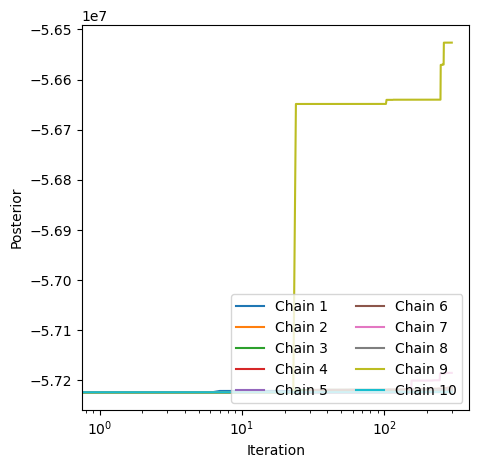

In [9]:
Bayes_mcmc_ini.Get_Posterior_plot()

In [10]:
Bayes_mcmc_ini.Chain_results_Components();